# BIOINF 580 - HW 04

### Due Friday, Dec. 5 at 11:59pm

---

## Submission Requirement:  

- Submit the Jupyter notebook (`.ipynb`) file with all code and the written report included.  

- Name the file as: `HW04_YourUniqueName.ipynb`

---

### Goal & Final Deliverables

For this homework, you will build a **binary classifier** to distinguish **pneumonia** from **normal** cases in chest X-ray images using **CNN-based methods**.

Your final submission must include:

1. **All of your code**, contained in this Jupyter notebook.  
2. A **report**, written as a **Markdown cell placed at the *end* of this notebook**, containing:

   - **Data & Preprocessing**  
     - Which dataset split was used for training vs. evaluation  
     - Any resizing, normalization, augmentation, or class-balancing steps you applied  

   - **Model & Training**  
     - Which CNN architecture(s) you explored  
       (e.g., **basic CNN**, **LeNet**, **AlexNet**, **VGG**, **ResNet**, **UNet encoder**, etc.)  
     - Training details such as loss function, optimizer, learning rate, batch size, number of epochs  
     - How you performed **K-fold cross-validation** on the training set to reduce overfitting and tune hyperparameters  
       (you may choose the value of **K** and decide which hyperparameters to tune)

   - **Results**  
     - Report the **mean ± standard deviation** of the F1 scores obtained from **K-fold cross-validation** on the training set  
     - Then report your **final best F1 score on the validation set** (after retraining your selected model on the full training set)

   - **Discussion**  
     - What worked well in your approach  
     - What could be improved in future iterations  

Please keep **all code and your written report within this single Jupyter notebook**, and **place your report as the final Markdown cell** at the bottom of the notebook.


### Grading Criteria (Total: 100 pts)

Your grade consists of **two components**:

#### **1. Model Performance (F1 Score) — 60 pts**

Performance is based on your **final best F1 score** on the PneumoniaMNIST validation set, using the following scoring rule:

| F1 Score Threshold | Score Formula (out of 60%) | Example Score |
|--------------------|---------------------------|----------------|
| **>= 0.98**       | **100% × 60**             | 60 pts         |
| **>= 0.97**       | **95% × 60**              | 57 pts         |
| **>= 0.96**       | **90% × 60**              | 54 pts         |
| **>= 0.94**       | **85% × 60**              | 51 pts         |
| **>= 0.92**       | **80% × 60**              | 48 pts         |
| **>= 0.90**       | **75% × 60**              | 45 pts         |
| **else**          | **70% × 60**              | 42 pts         |
| **NaN or error**  | **0%**                    | 0 pts          |

#### **2. Report Quality — 40 pts**

1. Clear description of **data preprocessing**  
2. Clear explanation of **model architecture(s)** and **training setup**  
3. Correct reporting of:  
   - **Mean ± std F1** from K-fold CV (training set)  
   - **Final best F1 score** on the validation set  
4. Quality of **discussion** (what worked well / what could be improved)  
5. **Organization, clarity, and completeness** of the report  
6. Report written in a **Markdown cell at the end** of this notebook  


### Task Description

Use the **PneumoniaMNIST** dataset from **MedMNIST**:

- **Training**: 4,708 images  
- **Validation**: 524 images  
- **Test**: 624 images  
- Labels: **0 = normal**, **1 = pneumonia**

For this homework, **the test set will NOT be used**.  
You only need the **training** and **validation** splits.

Use:

- **Training set** → for training and **K-fold cross-validation**  
- **Validation set** → for your **final F1 score evaluation** (this is the only score used for grading)


### CNN-based Methods

You may use **any CNN-based architecture** for this homework.  
Examples include: **Basic CNN, LeNet, AlexNet, VGG, ResNet, UNet (encoder), and EfficientNet.**  
Other CNN models are also allowed if you already know how to use them.

**Pretrained ImageNet models are allowed.**

---

## Installing MedMNIST

Uncomment and run the following inside a Jupyter notebook cell.
This ensures installation happens inside the **same environment** as your notebook kernel.

In [1]:
import sys
!{sys.executable} -m pip install medmnist

Using downloaded and verified file: C:\Users\Alessandra\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Alessandra\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Alessandra\.medmnist\pneumoniamnist.npz


C:\Users\Alessandra\AppData\Local\Temp\ipykernel_17032\2530982870.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels = [int(ds[i][1]) for i in range(n)]


=== Train ===
Num samples: 4708
Image shape: (1, 28, 28)
Class counts: {1: 3494, 0: 1214}

Showing examples from: Train


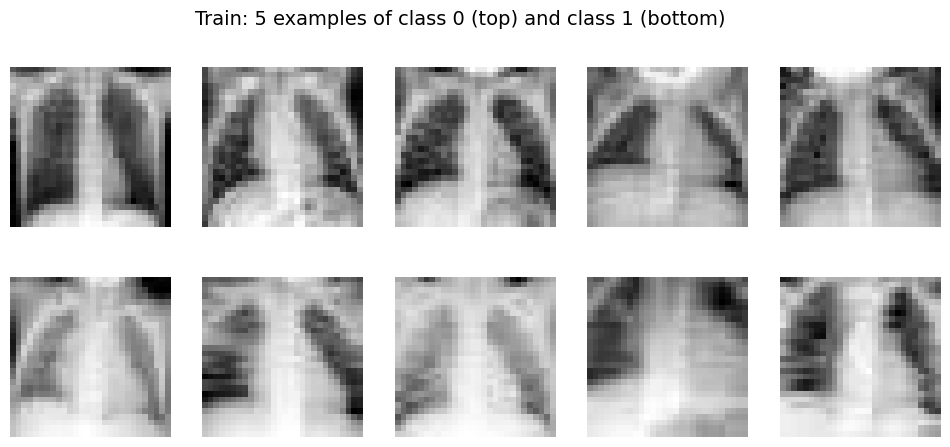


=== Validation ===
Num samples: 524
Image shape: (1, 28, 28)
Class counts: {1: 389, 0: 135}

Showing examples from: Validation


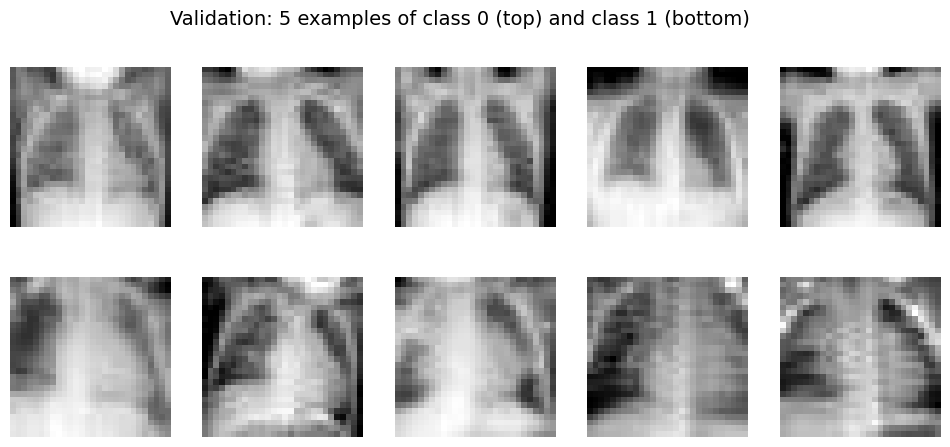

In [2]:
from medmnist import PneumoniaMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
from collections import Counter
import matplotlib.pyplot as plt

# --- Transform ---
transform = T.ToTensor()

# --- 1. Load datasets ---
train = PneumoniaMNIST(split='train', download=True, transform=transform)
val   = PneumoniaMNIST(split='val',   download=True, transform=transform)
test  = PneumoniaMNIST(split='test',  download=True, transform=transform)

# --- 2. Helper to compute class stats ---
def get_dataset_stats(ds, name="dataset"):
    n = len(ds)
    x0, y0 = ds[0]
    img_shape = tuple(x0.shape)

    labels = [int(ds[i][1]) for i in range(n)]
    counter = Counter(labels)

    print(f"=== {name} ===")
    print(f"Num samples: {n}")
    print(f"Image shape: {img_shape}")
    print("Class counts:", dict(counter))
    print()

# --- 3. Helper to plot 5 images of class 0 and 5 of class 1 ---
def show_examples(ds, name="dataset"):
    print(f"Showing examples from: {name}")

    class0_imgs = []
    class1_imgs = []

    # collect 5 images of each class
    for i in range(len(ds)):
        img, label = ds[i]
        if label == 0 and len(class0_imgs) < 5:
            class0_imgs.append(img.squeeze())
        if label == 1 and len(class1_imgs) < 5:
            class1_imgs.append(img.squeeze())
        if len(class0_imgs) == 5 and len(class1_imgs) == 5:
            break

    # plot
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle(f"{name}: 5 examples of class 0 (top) and class 1 (bottom)", fontsize=14)

    for idx in range(5):
        axes[0, idx].imshow(class0_imgs[idx], cmap='gray')
        axes[0, idx].axis('off')
        axes[1, idx].imshow(class1_imgs[idx], cmap='gray')
        axes[1, idx].axis('off')

    plt.show()
    print()

# --- 4. Print stats & show examples ---
get_dataset_stats(train, "Train")
show_examples(train, "Train")

get_dataset_stats(val, "Validation")
show_examples(val, "Validation")

---

---